### Used libraries

In [2]:
import numpy as np
import scipy as sp
from skimage.draw import line_nd
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
import cv2
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets as widgets
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

matplotlib.rcParams['figure.figsize'] = [14, 7]

### Chosing path to a file and parameters

In [52]:
wdg_path = widgets.Text(value='./example_photos/Kropka.jpg', placeholder='Type path to a file', description='Path to a file:', style= {'description_width': 'initial'})
wdg_scans = widgets.IntSlider(value=90, min=90, max=720, step = 90, description='Number of scans:', style= {'description_width': 'initial'})
wdg_detectors = widgets.IntSlider(value=180, min=90, max=720, step = 90, description='Number of detectors:', style= {'description_width': 'initial'})
wdg_kernel_size = widgets.IntSlider(value=21, min=1, max=101, step = 2, description='Kernel size:', style= {'description_width': 'initial'})
wdg_opening = widgets.IntSlider(value=135, min=45, max=270, step = 45, description='Opening width:', style= {'description_width': 'initial'})
wdg_display_steps = widgets.Checkbox(value=True,description='Show steps:',disabled=False,indent=False, style= {'description_width': 'initial'})
wdg_filtering = widgets.Checkbox(value=True,description='Filtering:',disabled=False,indent=False, style= {'description_width': 'initial'})
wdg_patient_name = widgets.Text(value='Name', placeholder='Type the name of the patient', description='Patient name:', style= {'description_width': 'initial'})
wdg_patient_ID = widgets.Text(value='1', placeholder='Type the ID of the patient', description='Patient ID:', style= {'description_width': 'initial'})
wdg_image_comments = widgets.Text(value='Some comment', placeholder='Type the comment to an image', description='Image comments:', style= {'description_width': 'initial'})
wdg_study_date = widgets.Text(value='20220101', placeholder='Type the study date', description='Study date (format - YearMonthDay):', style= {'description_width': 'initial'})
wdg_file_name = widgets.Text(value='dicom_output', placeholder='Type the name of output DICOM file', description='DICOM file name:', style= {'description_width': 'initial'})


display(wdg_path)
display(wdg_scans)
display(wdg_detectors)
display(wdg_opening)
display(wdg_kernel_size)
display(wdg_display_steps)
display(wdg_filtering)
display(wdg_patient_name)
display(wdg_patient_ID)
display(wdg_image_comments)
display(wdg_study_date)
display(wdg_file_name)

Text(value='./example_photos/Kropka.jpg', description='Path to a file:', placeholder='Type path to a file', st…

IntSlider(value=90, description='Number of scans:', max=720, min=90, step=90, style=SliderStyle(description_wi…

IntSlider(value=180, description='Number of detectors:', max=720, min=90, step=90, style=SliderStyle(descripti…

IntSlider(value=135, description='Opening width:', max=270, min=45, step=45, style=SliderStyle(description_wid…

IntSlider(value=21, description='Kernel size:', max=101, min=1, step=2, style=SliderStyle(description_width='i…

Checkbox(value=True, description='Show steps:', indent=False, style=DescriptionStyle(description_width='initia…

Checkbox(value=True, description='Filtering:', indent=False, style=DescriptionStyle(description_width='initial…

Text(value='Name', description='Patient name:', placeholder='Type the name of the patient', style=DescriptionS…

Text(value='1', description='Patient ID:', placeholder='Type the ID of the patient', style=DescriptionStyle(de…

Text(value='Some comment', description='Image comments:', placeholder='Type the comment to an image', style=De…

Text(value='20220101', description='Study date (format - YearMonthDay):', placeholder='Type the study date', s…

Text(value='dicom_output', description='DICOM file name:', placeholder='Type the name of output DICOM file', s…

### Loading parameters

Loaded: 90 180 135 21 True


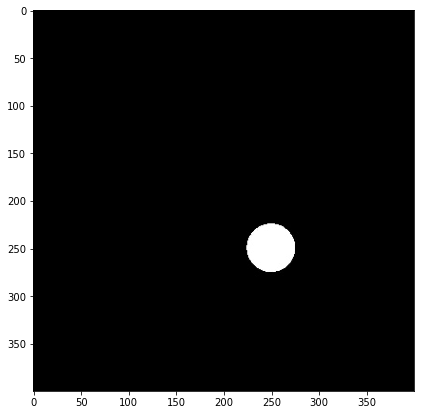

In [53]:
input_img = plt.imread(wdg_path.value)

if len(np.shape(input_img)) == 3:
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    
scans = wdg_scans.value
detectors = wdg_detectors.value
opening = wdg_opening.value
kernel_size = wdg_kernel_size.value
display_steps = wdg_display_steps.value
patient_data = {"PatientName": wdg_patient_name.value, "PatientID": wdg_patient_ID.value, "ImageComments": wdg_image_comments.value, "StudyDate": wdg_study_date.value}
file_name = wdg_file_name.value

print("Loaded:", scans, detectors, opening, kernel_size, display_steps)

plt.imshow(input_img, cmap = 'gray')
plt.show()

### Finding the circle described over an image

In [54]:
# Image shape
img_heigth, img_width = np.shape(input_img)
print("Shape:", img_heigth, img_width)

# Center of mass
cx = int(img_width / 2)
cy = int(img_heigth / 2)
print("Center:", cx, cy)

# Radius
radius = int(np.floor(0.5 * np.sqrt(img_heigth**2 + img_width**2)))
print("Radius:", radius)

Shape: 400 400
Center: 200 200
Radius: 282


### Scanning

In [55]:
# Progress bar widget
wdg_scanning_progress = widgets.FloatProgress(value=0, min=0,max=scans,description='Progress:',bar_style='success',style={'bar_color': 'blue'},orientation='horizontal')
display(wdg_scanning_progress)

# Scanning parameters
alpha = 360 / scans
step = alpha
alpha = 0
n = detectors
l = opening

# Array saving steps of scanning
shots = []

# Emitters and detectors positions
E = []
D = []

# Sinogram and array saving steps of sinogram
sinogram = []
sinogram_shots = []

# Prepare preview image so that emitters and detectors will be seen
border_width = max(2 * radius - img_width, 2 * radius - img_heigth)
preview_img = deepcopy(input_img)
preview_img = cv2.cvtColor(preview_img,cv2.COLOR_GRAY2RGB)
preview_img = cv2.copyMakeBorder(preview_img, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value = (0,0,0))

for s in range(scans):
    wdg_scanning_progress.value = s
    
    if display_steps and s == 0:
        sinogram_shots.append(np.zeros((scans, n)))
        
    if display_steps and (s + 1) % 10 == 0:
        sinogram_shots.append(deepcopy(sinogram_shots[-1]))
    
    if display_steps and (s + 1) % 10 == 0:
        shots.append(deepcopy(preview_img))
        cv2.circle(shots[-1], (cx + border_width, cy + border_width), radius, (255,0,255), 1)

    # Calculating emiter's position
    xe = radius * np.cos(np.deg2rad(alpha))
    ye = radius * np.sin(np.deg2rad(alpha))

    E.append((int(cx + xe), int(cy + (-1)*ye)))

    # Drawing emiter over an image
    if display_steps and (s + 1) % 10 == 0:
        cv2.circle(shots[-1], (E[-1][0] + border_width, E[-1][1] + border_width), 7, (0,255,0), 3)

    D.append([])
    sinogram.append([])

    for i in range(n):
        # Calculating detector's position
        xd = radius * np.cos(np.deg2rad(alpha + 180 - l / 2 + i * (l / (n-1))))
        yd = radius * np.sin(np.deg2rad(alpha + 180 - l / 2 + i * (l / (n-1))))

        D[-1].append((int(xd + cx), int((-1)*yd + cy)))

        # Drawing detector on the image
        if display_steps and (s + 1) % 10 == 0:
            cv2.circle(shots[-1], (D[-1][-1][0] + border_width, D[-1][-1][1] + border_width), 3, (255,0,0), 1)

        # Calculating points of the line
        line_x_points, line_y_points = line_nd(E[-1], D[-1][-1])

        brightness = 0
        sumof = 0

        for (x, y) in zip(line_x_points, line_y_points):
            # Drawing line on the image
            if display_steps and (s + 1) % 10 == 0:
                cv2.circle(shots[-1], (x + border_width, y + border_width), 0, (0,0,255), -1)

            # Calculating mean brightness
            if x >= 0 and y < img_heigth and y >= 0 and x < img_width:
                brightness += input_img[y][x]
                sumof += 1

        # Adding results to sinogram
        if sumof != 0:
            brightness = brightness / sumof
        else:
            brightness = 0
        sinogram[-1].append(brightness)
        
        if display_steps:
            sinogram_shots[-1][s][i] = brightness

    alpha += step

FloatProgress(value=0.0, bar_style='success', description='Progress:', max=90.0, style=ProgressStyle(bar_color…

### Scannig step by step

In [56]:
def display_shot(n):
    plt.subplot(1,2,1)
    plt.imshow(shots[int((n-9)/10)])
    plt.subplot(1,2,2)
    plt.imshow(sinogram_shots[int((n-9)/10)], cmap='gray')
    plt.show()
    
if display_steps:
    widgets.interact(display_shot, n = (9, scans - 1, 10))

interactive(children=(IntSlider(value=49, description='n', max=89, min=9, step=10), Output()), _dom_classes=('…

### Sinogram

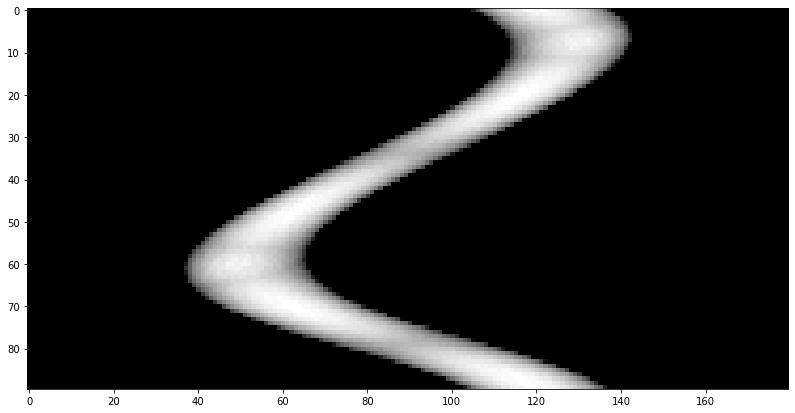

In [57]:
plt.imshow(sinogram, cmap='gray')
plt.show()

### Sinogram filtration

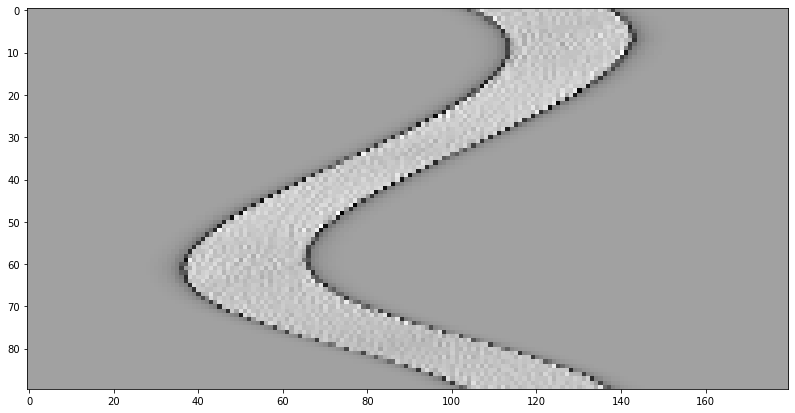

In [58]:
sinogram = np.array(sinogram)

if wdg_filtering.value:
    kernel = []
    for k in range(-int(np.floor(kernel_size/2)), int(np.ceil(kernel_size/2))):
        if k == 0:
            kernel.append(1)
        else:
            if k % 2 == 0:
                kernel.append(0)
            else:
                kernel.append((-4 / np.pi**2)/(k**2))

    for i in range(len(sinogram)):
        sinogram[i] = np.convolve(sinogram[i], kernel, mode='same')

    plt.imshow(sinogram, cmap='gray')
    plt.show()


### Backtracing

In [59]:
backshots = []
blank_image = np.zeros((img_heigth, img_width))

wdg_backtracing_progress = widgets.FloatProgress(value=0, min=0,max=len(sinogram),description='Progress:',bar_style='success',style={'bar_color': 'blue'},orientation='horizontal')
display(wdg_backtracing_progress)

for i in range(len(sinogram)):
    wdg_backtracing_progress.value = i
    if i == 0:
        backshots.append(deepcopy(blank_image))
    else:
        backshots.append(deepcopy(backshots[-1]))
    for j in range(n):
        line_x_points, line_y_points = line_nd(E[i], D[i][j])
        for (x, y) in zip(line_x_points, line_y_points):
            if x >= 0 and y < img_heigth and y >= 0 and x < img_width:
                backshots[-1][y][x] += sinogram[i][j]


FloatProgress(value=0.0, bar_style='success', description='Progress:', max=90.0, style=ProgressStyle(bar_color…

### Backtracking step by step

In [60]:
def display_backshot(n):
    plt.subplot(1,2,1)
    plt.imshow(backshots[n-1], cmap = 'gray')
    plt.subplot(1,2,2)
    p_low, p_high = np.percentile(backshots[n-1], (10,99.9))
    plt.imshow(rescale_intensity(backshots[n-1],  in_range=(p_low, p_high), out_range=(0,255)), cmap = 'gray')
    plt.show()
    
if display_steps:
    widgets.interact(display_backshot, n = (1, scans, 1))
else:
    plt.imshow(backshots[-1], cmap = 'gray')
    plt.show()

interactive(children=(IntSlider(value=45, description='n', max=90, min=1), Output()), _dom_classes=('widget-in…

### Save as DICOM

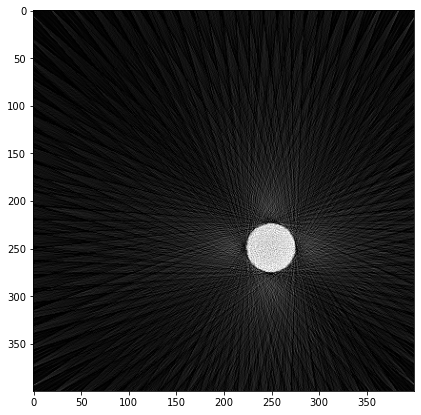

In [61]:
def convert_image_to_ubyte(img):
    p_low, p_high = np.percentile(img, (10,99.9))
    return img_as_ubyte(rescale_intensity(img, in_range=(p_low, p_high), out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.StudyDate = patient_data["StudyDate"]
    
    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)

    #show image
    plt.imshow(ds.pixel_array, cmap = 'gray')


save_as_dicom(file_name, backshots[-1], patient_data)

### RMSE

Backshots, min: -23.179705523404145 max: 98.9012559172861
Percentiles, -0.9582093117018227 84.0943879617069
Final result, min: 0 max: 255
RMSE Final result: 23.907258704209482


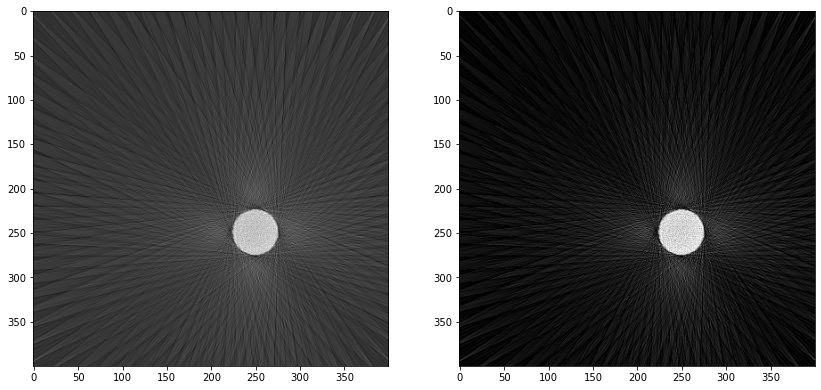

In [62]:
#https://stackoverflow.com/questions/20271479/what-does-it-mean-to-get-the-mse-mean-error-squared-for-2-images
#https://pl.wikipedia.org/wiki/B%C5%82%C4%85d_%C5%9Bredniokwadratowy - RMSE to pierwiastek z MSE

input_img = rescale_intensity(input_img, out_range=(0, 255)).astype(np.uint8)

p_low, p_high = np.percentile(backshots[-1], (10,99.9))
final_result = rescale_intensity(backshots[-1], in_range=(p_low, p_high), out_range=(0, 255)).astype(np.uint8)

print("Backshots, min:", backshots[-1].min(), "max:", backshots[-1].max())
print("Percentiles,", p_low, p_high)
print("Final result, min:", final_result.min(), "max:", final_result.max())

RMSE = 0
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        RMSE += (float(input_img[i][j]) - float(final_result[i][j]))**2
RMSE = RMSE / (input_img.shape[0]*input_img.shape[1])
RMSE = RMSE**(0.5)

print("RMSE Final result:", RMSE)

plt.subplot(1,2,1)
plt.imshow(backshots[-1], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(final_result, cmap = 'gray')
plt.show()

### DICOM Reading

In [70]:
wdg_dicom_path = widgets.Text(value='dicom_output', placeholder='Type the path of DICOM file to rad', description='DICOM file path:', style= {'description_width': 'initial'})
display(wdg_dicom_path)

Text(value='dicom_output', description='DICOM file path:', placeholder='Type the path of DICOM file to rad', s…

File path........: dicom_output
Patient's Name...: Name
Patient ID.......: 1
Modality.........: CT
Study Date.......: 20220101
Image comment....: Some comment
Image size.......: 400 x 400


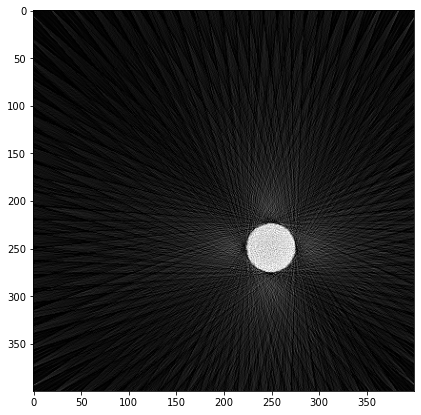

In [76]:
import matplotlib.pyplot as plt
from pydicom import dcmread

fpath = wdg_dicom_path.value
ds = dcmread(fpath)
print("File path........:", fpath)
print("Patient's Name...:", ds.get('PatientName', 'this tag does not exist'))
print("Patient ID.......:", ds.get('PatientID', 'this tag does not exist'))
print("Modality.........:", ds.get('Modality', 'this tag does not exist'))
print("Study Date.......:", ds.get('StudyDate', 'this tag does not exist'))
print("Image comment....:", ds.get('ImageComments', 'this tag does not exist'))
print("Image size.......:", ds.get('Rows', 'this tag does not exist'), 'x', ds.get('Columns', 'this tag does not exist'))
plt.imshow(ds.pixel_array, cmap="gray")
plt.show()